In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [2]:
tensor_transform = transforms.ToTensor()
train_dataset = datasets.MNIST(
    root="../../data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

# Normal Auto Encoder

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Variational Auto Encoder

In [4]:
class vae(nn.Module):
    def __init__(self):
        super(vae, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
        )

        self.mu_vec = nn.Linear(18, 9)
        self.var_vec = nn.Linear(18, 9)


        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def decode(self, z):
        return self.decoder(z)

    def reparameter(self, mu, var):
        epsilon = torch.randn_like(var)
        latent = mu + var * epsilon
        return latent

    def forward(self, x):
        dist = self.encoder(x)
        mu = self.mu_vec(dist)
        var = self.var_vec(dist)
        latent = self.reparameter(mu, var)
        recon = self.decoder(latent)
        return recon, latent, mu, var

In [5]:
def vae_loss(recon, x, mu, log_var):
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
    D_kl = (-0.5) * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + D_kl

In [6]:
model = vae()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
outputs = []
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Cuda Avalible")
model.to(device)

Cuda Avalible


vae(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
  )
  (mu_encoder): Linear(in_features=18, out_features=9, bias=True)
  (var_encoder): Linear(in_features=18, out_features=9, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)

In [ ]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for images, _ in train_loader:
            images = images.view(-1, 28*28).to(device)

            # Pass
            recon, latent, mu, var = model(images)
            loss = vae_loss(recon, images, mu, var)
            
            # Back Prop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Evaluate
            overall_loss += loss.item()
            losses.append(loss.item())

        outputs.append((epoch, images, recon, mu, var))
        print(f"Epoch [{epoch+1}/{epochs}]; Loss: {loss.item():.4f}")

In [18]:
train(model, optimizer, 20, device)

Epoch [1/20], Loss: 4227.323242
Epoch [2/20], Loss: 3402.875977
Epoch [3/20], Loss: 3187.525635
Epoch [4/20], Loss: 3881.800049
Epoch [5/20], Loss: 3520.373779
Epoch [6/20], Loss: 3688.413574
Epoch [7/20], Loss: 3381.397217
Epoch [8/20], Loss: 3439.439941
Epoch [9/20], Loss: 3456.467773
Epoch [10/20], Loss: 3480.898682
Epoch [11/20], Loss: 3691.408203
Epoch [12/20], Loss: 3241.570068
Epoch [13/20], Loss: 3051.584717
Epoch [14/20], Loss: 3679.333496
Epoch [15/20], Loss: 3024.934326
Epoch [16/20], Loss: 3132.475586
Epoch [17/20], Loss: 3263.699219
Epoch [18/20], Loss: 3207.078613
Epoch [19/20], Loss: 3439.666016
Epoch [20/20], Loss: 3175.570557


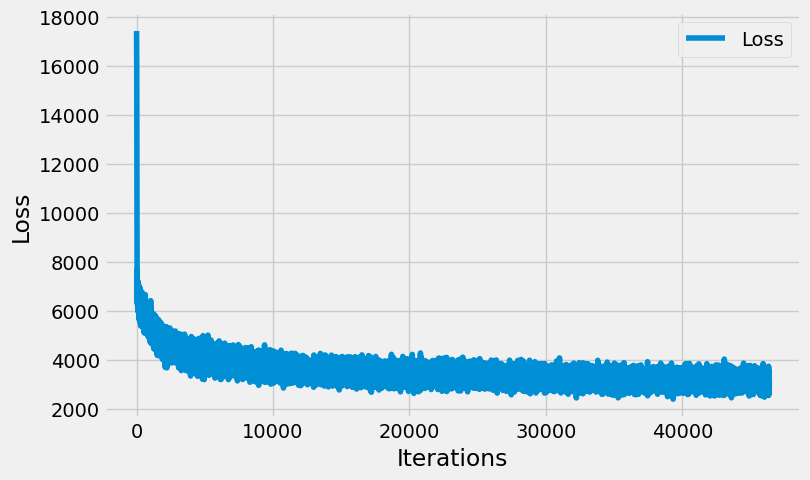

In [19]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

In [8]:
model.train()
cnt = 0
for epoch in range(20):
    overall_loss = 0
    cnt += 1
    for images, _ in train_loader:
        images = images.view(32, 28*28).to(device)

        # Pass
        recon, latent, mu, var = model(images)
        loss = vae_loss(recon, images, mu, var)
        
        # Back Prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate
        overall_loss += loss.item()
        losses.append(loss.item())

    outputs.append((epoch, images, latent, recon, mu, var))
    print(f"Epoch [{epoch+1}/{epochs}]; Loss: {loss.item():.4f}; AVG_Loss: {overall_loss/(cnt * 32):.4f}")

Epoch [1/20]; Loss: 4708.8291; AVG_Loss: 340269.8240
Epoch [2/20]; Loss: 4532.4043; AVG_Loss: 136045.4550
Epoch [3/20]; Loss: 4272.9478; AVG_Loss: 86047.9046
Epoch [4/20]; Loss: 4128.4785; AVG_Loss: 62067.1722
Epoch [5/20]; Loss: 4166.6011; AVG_Loss: 47470.5654
Epoch [6/20]; Loss: 3780.5581; AVG_Loss: 38284.6746
Epoch [7/20]; Loss: 3638.9607; AVG_Loss: 31894.1779
Epoch [8/20]; Loss: 3378.2649; AVG_Loss: 27258.1340
Epoch [9/20]; Loss: 3723.3896; AVG_Loss: 23544.8541
Epoch [10/20]; Loss: 3634.7456; AVG_Loss: 20577.2559
Epoch [11/20]; Loss: 3406.9202; AVG_Loss: 18192.9288
Epoch [12/20]; Loss: 3622.1541; AVG_Loss: 16357.9289
Epoch [13/20]; Loss: 3520.5425; AVG_Loss: 14894.8538
Epoch [14/20]; Loss: 3189.9001; AVG_Loss: 13685.2074
Epoch [15/20]; Loss: 3400.2644; AVG_Loss: 12661.5714
Epoch [16/20]; Loss: 3307.2610; AVG_Loss: 11783.9798
Epoch [17/20]; Loss: 3365.2222; AVG_Loss: 11023.5463
Epoch [18/20]; Loss: 3139.2542; AVG_Loss: 10354.7059
Epoch [19/20]; Loss: 3269.1050; AVG_Loss: 9763.0008
E

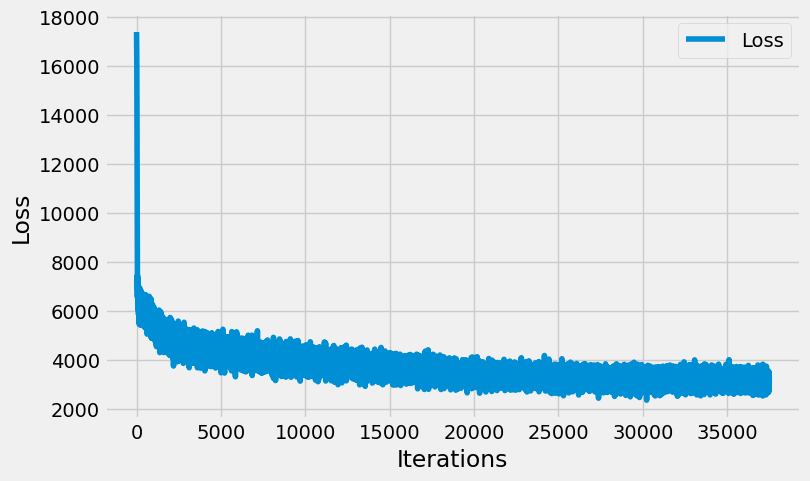

In [9]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

In [14]:
torch.save(model, "../../output/s2/vae_1.pth")
print("Saved")

Saved


# Fix VAE

In [25]:
class vae(nn.Module):
    def __init__(self):
        super(vae, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
        )

        self.mu_encoder = nn.Linear(18, 9)
        self.var_encoder = nn.Linear(18, 9)

        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, var = self.mu_encoder(x), self.var_encoder(x)
        return mean, var

    def decode(self, z):
        return self.decoder(z)

    def reparameter(self, mu, var):
        epsilon = torch.randn_like(var)
        latent = mu + var * epsilon
        return latent

    def forward(self, x):
        mean, var = self.encode(x)
        std = torch.exp(0.5 * var)
        z = self.reparameter(mean, std)
        x_hat = self.decode(z)
        return x, x_hat, z, mean, var

In [26]:
model = vae().to(device)
epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3)
outputs = []
losses = []
losses_recon = []
losses_kl = []

In [ ]:
def vae_loss(recon, x, mu, log_var):
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
    D_kl = (-0.5) * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + D_kl, recon_loss, D_kl

In [33]:
loss_function = nn.MSELoss()
def vae_loss(recon, x, mu, log_var):
    recon_loss = loss_function(recon, x)
    D_kl = (-0.5) * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + D_kl, recon_loss, D_kl

In [34]:
model.train()
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(32, 28*28).to(device)

        optimizer.zero_grad()
        x, x_hat, z, mean, var = model(x)
        loss, recon_loss, KL = vae_loss(x_hat, x, mean, var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        losses_recon.append(recon_loss.item())
        losses_kl.append(KL.item())
    outputs.append((x, x_hat, z, mean, var))

    print(f"Epoch [{epoch + 1}/{epochs}]\tAVG_LOSS: {overall_loss/(batch_idx*32)}")

Epoch [1/20]	AVG_LOSS: 0.0034527965480776798
Epoch [2/20]	AVG_LOSS: 0.002107867583301487
Epoch [3/20]	AVG_LOSS: 0.0021061777674444932
Epoch [4/20]	AVG_LOSS: 0.002105251793451945
Epoch [5/20]	AVG_LOSS: 0.0021049762196245474
Epoch [6/20]	AVG_LOSS: 0.0021092027931806125
Epoch [7/20]	AVG_LOSS: 0.0021043183175666036
Epoch [8/20]	AVG_LOSS: 0.002103984327040108
Epoch [9/20]	AVG_LOSS: 0.002103998276565061
Epoch [10/20]	AVG_LOSS: 0.0021039393254985144
Epoch [11/20]	AVG_LOSS: 0.0021038338129002136
Epoch [12/20]	AVG_LOSS: 0.0021038164996309452
Epoch [13/20]	AVG_LOSS: 0.0021037291015424788
Epoch [14/20]	AVG_LOSS: 0.002103723405081115
Epoch [15/20]	AVG_LOSS: 0.0021037647446340174
Epoch [16/20]	AVG_LOSS: 0.0021036254049362287
Epoch [17/20]	AVG_LOSS: 0.0021035751563187773
Epoch [18/20]	AVG_LOSS: 0.0021036058953682927
Epoch [19/20]	AVG_LOSS: 0.0021035511971882713
Epoch [20/20]	AVG_LOSS: 0.002103509674066918


## Binary Cross Entropy loss + D_KL

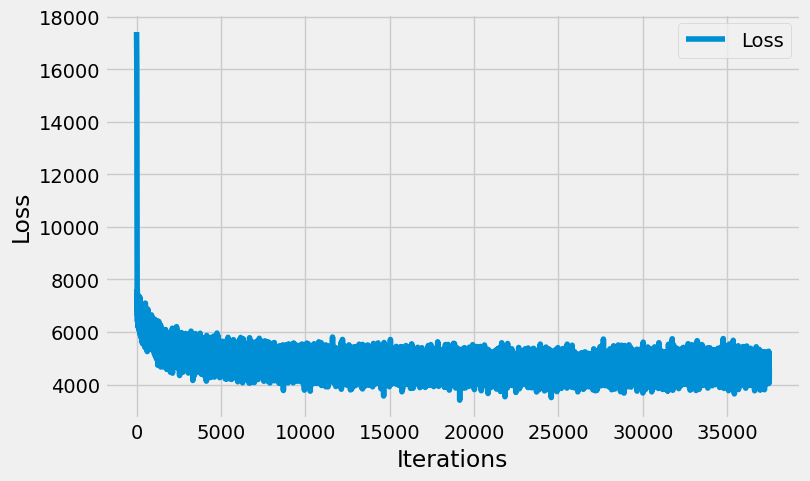

In [20]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

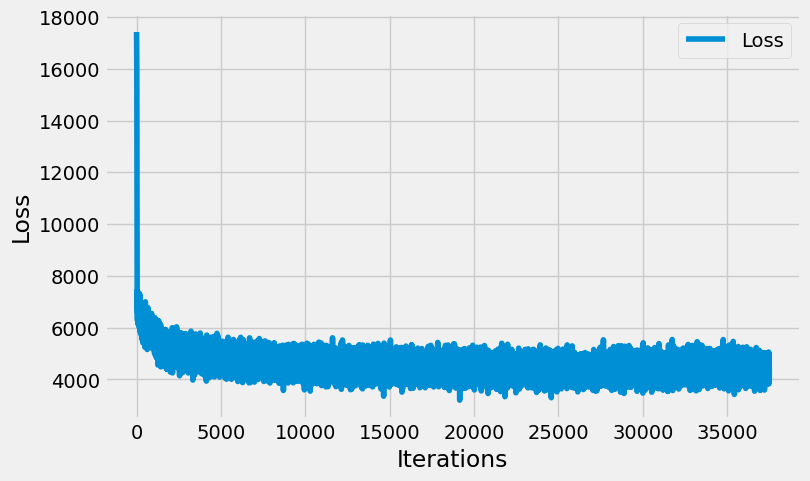

In [21]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses_recon, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

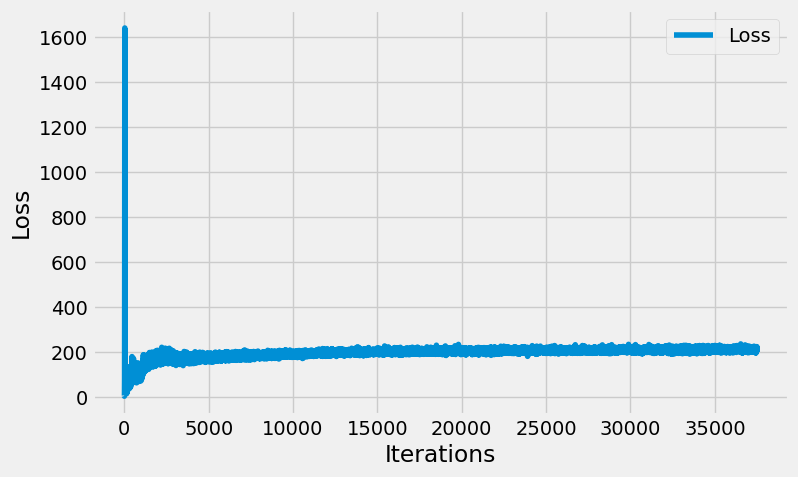

In [22]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses_kl, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

## MSE LOSS

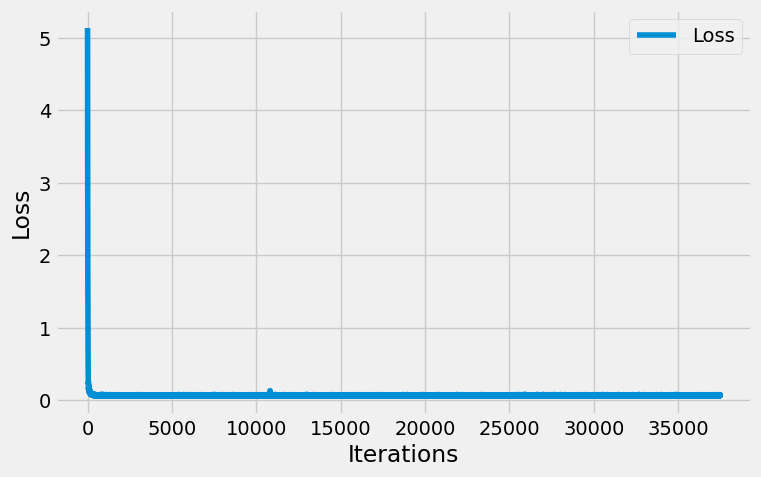

In [35]:

plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

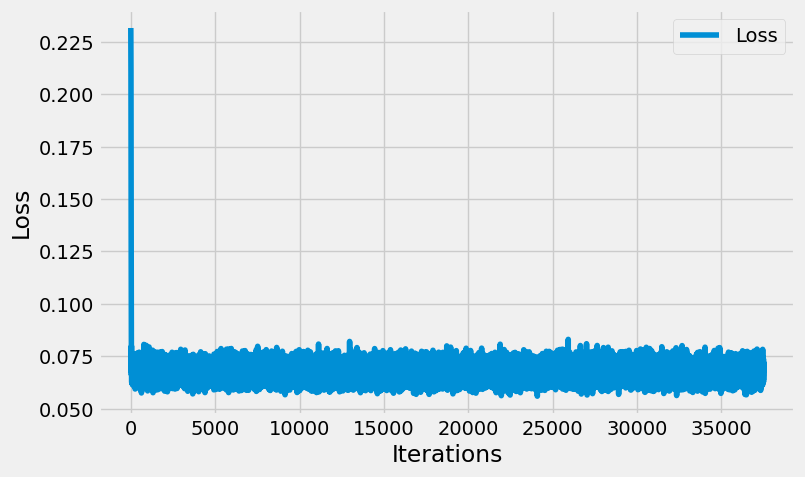

In [36]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses_recon, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

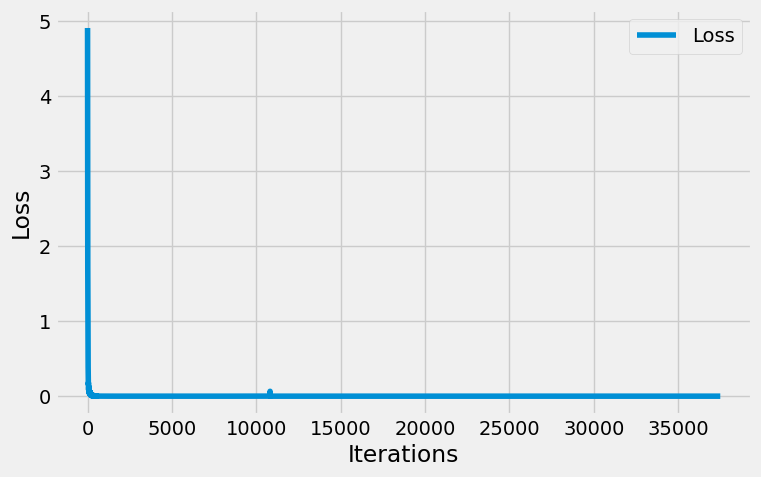

In [37]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses_kl, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

# MRL VAE ?

In [15]:
class vae(nn.Module):
    def __init__(self, latent_dim=10):
        super(vae, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        self.mu_encoder = nn.Linear(64, latent_dim)
        self.var_encoder = nn.Linear(64, latent_dim)

        self.decoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(k, 64),
                nn.ReLU(),
                nn.Linear(64, 128),
                nn.ReLU(),
                nn.Linear(128, 28 * 28),
                nn.Sigmoid()
            ) for k in range(1, latent_dim + 1)
        ])

    def encode(self, x):
        x = self.encoder(x)
        mean, var = self.mu_encoder(x), self.var_encoder(x)
        return mean, var

    def reparameter(self, mu, std):
        epsilon = torch.randn_like(std)
        latent = mu + std * epsilon
        return latent

    def forward(self, x):
        mean, var = self.encode(x)
        std = torch.exp(0.5 * var)
        z = self.reparameter(mean, std)
        recons = []
        for k in range(1, self.latent_dim + 1):
            z_k = z[:, :k]
            recon = self.decoder[k-1](z_k)
            recons.append(recon)
        return z, recons, mean, var

In [17]:
def vae_loss(recon, x, mu, log_var):
    recon_loss = F.binary_cross_entropy(recon, x, reduction='sum')
    D_kl = (-0.5) * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + D_kl, recon_loss, D_kl

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = vae(latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
outputs = []
losses = [[] for _ in range(10)]

In [19]:
for epoch in range(epochs):
    for images, _ in loader:
        images = images.view(-1, 28 * 28).to(device)
        
        optimizer.zero_grad()
        z, reconstructions, mean, var = model(images)
        
        total_loss = 0
        for k in range(10):
            loss_k = vae_loss(reconstructions[k], images, mean, var)
            losses[k].append(loss_k.item())
            total_loss += loss_k
        
        total_loss.backward()
        optimizer.step()

    sample_images = images.detach().cpu()
    sample_recons = [r.detach().cpu() for r in reconstructions]
    outputs.append((epoch, sample_images, sample_recons, z))
    print(f"Epoch {epoch + 1}/{epochs}, Loss (10d): {losses[9][-1]:.4f}")

AttributeError: 'vae' object has no attribute 'decoder'